# Projet data mining  
#### Sujet : Analyse et prédiction de l'absenteisme au travail.
###### BUT SD 23-24

Algassimou DIALLO

# Plan
1. [Introduction](#introduction)
2. [Data Prepocessing](#datapreprocessing)
3. [Exploratory Data Analysis](#EDA)
4. [Models](#models)
5. [Conclusion](#conclusion)


### Packages needed 

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math



<a name="datapreprocessing"></a>
# Data preprocessing 

In [71]:
df = pd.read_csv("Absenteeism_at_work.csv", sep =";")
df.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


- Nous avons 740 observations de 20 variables 
- Pas de NA dans les variables
- Les types des variables semblent correctes.

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               740 non-null    int64  
 1   Reason for absence               740 non-null    int64  
 2   Month of absence                 740 non-null    int64  
 3   Day of the week                  740 non-null    int64  
 4   Seasons                          740 non-null    int64  
 5   Transportation expense           740 non-null    int64  
 6   Distance from Residence to Work  740 non-null    int64  
 7   Service time                     740 non-null    int64  
 8   Age                              740 non-null    int64  
 9   Work load Average/day            740 non-null    float64
 10  Hit target                       740 non-null    int64  
 11  Disciplinary failure             740 non-null    int64  
 12  Education             

In [73]:
df.describe()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,...,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,18.017568,19.216216,6.324324,3.914865,2.544595,221.329730,29.631081,12.554054,36.450000,271.490235,...,0.054054,1.291892,1.018919,0.567568,0.072973,0.745946,79.035135,172.114865,26.677027,6.924324
std,11.021247,8.433406,3.436287,1.421675,1.111831,66.952223,14.836788,4.384873,6.478772,39.058116,...,0.226277,0.673238,1.098489,0.495749,0.260268,1.318258,12.883211,6.034995,4.285452,13.330998
min,1.000000,0.000000,0.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,205.917000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000,0.000000
25%,9.000000,13.000000,3.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,244.387000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,2.000000
50%,18.000000,23.000000,6.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,264.249000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,3.000000
75%,28.000000,26.000000,9.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,294.217000,...,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,8.000000
max,36.000000,28.000000,12.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,378.884000,...,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000,120.000000


On remarque des "min = 0" pour "Reason for absence" et "Month of absence" ce qui est bizarre comparé à la documentation du dataset.

 - Pour la variable "Reason for absence" on remarque que ces valeurs nulles correspondent à une "non absence"(l'individu n'a pas été absent) car on remarque que ces individus ont tous un taux d'absence nulle. Ces informations sont très importantes, ce ne sont pas des erreurs donc on doit garder ces lignes.

In [74]:
df[df["Reason for absence"] ==0]

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
50,20,0,9,2,4,260,50,11,36,241.476,...,1,1,4,1,0,0,65,168,23,0
51,29,0,9,2,4,225,26,9,28,241.476,...,1,1,1,0,0,2,69,169,24,0
54,11,0,9,3,4,289,36,13,33,241.476,...,1,1,2,1,0,1,90,172,30,0
55,36,0,9,3,4,118,13,18,50,241.476,...,1,1,1,1,0,0,98,178,31,0
58,13,0,9,4,4,369,17,12,31,241.476,...,1,1,3,1,0,0,70,169,25,0
64,36,0,10,4,4,118,13,18,50,253.465,...,1,1,1,1,0,0,98,178,31,0
203,2,0,4,2,3,235,29,12,48,326.452,...,1,1,1,0,1,5,88,163,33,0
213,7,0,5,4,3,279,5,14,39,378.884,...,1,1,2,1,1,0,68,168,24,0
214,18,0,5,4,3,330,16,4,28,378.884,...,1,2,0,0,0,0,84,182,25,0


- Pour la variable "month of absence" on remarque que ces individus ont tous un taux d'absence nul et ils ne sont qu'au nombre de 3. 
- On decide donc remplacer ces valeurs par le mois moyen des individus précédants(raison = 0 & taux d'absence = 0). 

In [75]:
df[df["Month of absence"]==0]

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
737,4,0,0,3,1,118,14,13,40,271.219,...,0,1,1,1,0,8,98,170,34,0
738,8,0,0,4,2,231,35,14,39,271.219,...,0,1,2,1,0,2,100,170,35,0
739,35,0,0,6,3,179,45,14,53,271.219,...,0,1,1,0,0,1,77,175,25,0


In [76]:
df[df["Reason for absence"] ==0].mean()


ID                                  18.046512
Reason for absence                   0.000000
Month of absence                     7.325581
Day of the week                      3.860465
Seasons                              3.162791
Transportation expense             246.604651
Distance from Residence to Work     26.488372
Service time                        12.627907
Age                                 39.604651
Work load Average/day              275.880023
Hit target                          92.441860
Disciplinary failure                 0.930233
Education                            1.116279
Son                                  1.348837
Social drinker                       0.674419
Social smoker                        0.186047
Pet                                  1.046512
Weight                              83.534884
Height                             171.837209
Body mass index                     28.325581
Absenteeism time in hours            0.000000
dtype: float64

 - On remplace donc par le mois de Juillet (7)

In [77]:
df["Month of absence"] = df["Month of absence"].replace([0],7)


<a name="EDA"></a>
# Exploratory Data Analysis 

- Reason for absence & Absenteeism time

On remarque que la raison d'absence la plus fréquente  est la raison 23 ("medical consultation") suivi de 28 ("Dental consultation") et de 13 ("Diseases of the musculoskeletal system and connective tissue")

In [20]:
df.groupby('Reason for absence')['Absenteeism time in hours'].count()

Reason for absence
0      43
1      16
2       1
3       1
4       2
5       3
6       8
7      15
8       6
9       4
10     25
11     26
12      8
13     55
14     19
15      2
16      3
17      1
18     21
19     40
21      6
22     38
23    149
24      3
25     31
26     33
27     69
28    112
Name: Absenteeism time in hours, dtype: int64

 #### Graphique pour mieux visualiser ces données : 

Text(0.5, 0, 'Count of people')

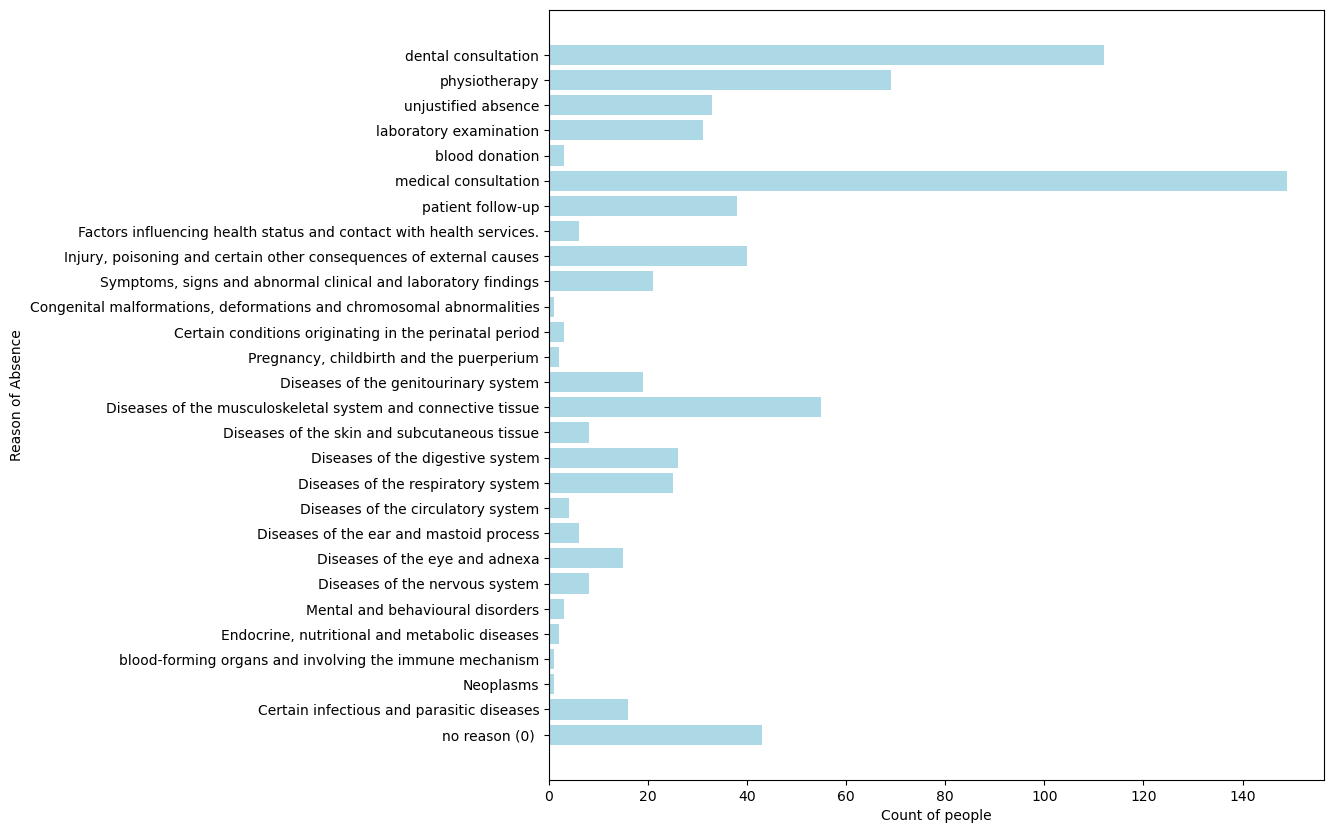

In [21]:
top_raison=df.groupby('Reason for absence')['Absenteeism time in hours'].count()
top_raison=np.array(top_raison) 
fig= plt.subplots(figsize=(10,10))

table=["no reason (0) ",'Certain infectious and parasitic diseases', 'Neoplasms', 'blood-forming organs and involving the immune mechanism', 'Endocrine, nutritional and metabolic diseases', 'Mental and behavioural disorders', 'Diseases of the nervous system', 'Diseases of the eye and adnexa', 'Diseases of the ear and mastoid process', 'Diseases of the circulatory system', 'Diseases of the respiratory system', 'Diseases of the digestive system', 'Diseases of the skin and subcutaneous tissue', 'Diseases of the musculoskeletal system and connective tissue', 'Diseases of the genitourinary system','Pregnancy, childbirth and the puerperium','Certain conditions originating in the perinatal period','Congenital malformations, deformations and chromosomal abnormalities', 'Symptoms, signs and abnormal clinical and laboratory findings', 'Injury, poisoning and certain other consequences of external causes', 'Factors influencing health status and contact with health services.','patient follow-up','medical consultation','blood donation','laboratory examination','unjustified absence','physiotherapy','dental consultation']

plt.barh(y=np.arange(len(top_raison)),width=top_raison,label='No. of people',color='lightblue')
plt.yticks(np.arange(len(top_raison)),table,rotation=0)

plt.ylabel('Reason of Absence')
plt.xlabel('Count of people')

- Month of absence & Absenteeism

Le mois de Mars compte le plus d'absences suivi de Février et Octobre.
Ce qui est compréhensible car le mois de Mars est le mois des "festival" au Brésil.(festival de rio)

In [22]:
df.groupby('Month of absence')['Absenteeism time in hours'].count()

Month of absence
1     50
2     72
3     87
4     53
5     64
6     54
7     70
8     54
9     53
10    71
11    63
12    49
Name: Absenteeism time in hours, dtype: int64

#### Graphique pour mieux visualiser la variation par mois.

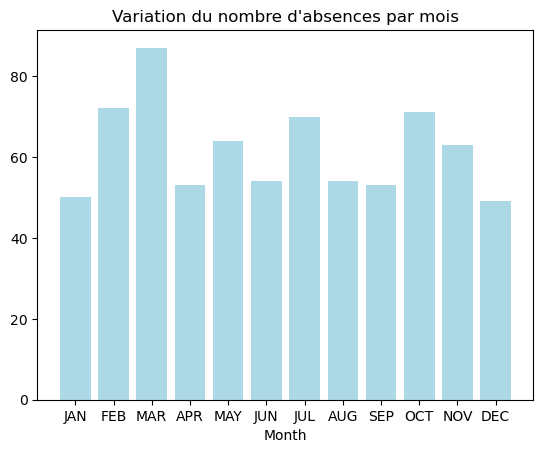

In [23]:
mois_absence = np.array(df.groupby('Month of absence')['Absenteeism time in hours'].count())


plt.bar(x=np.arange(len(mois_absence)),height=mois_absence ,color='lightblue')
plt.xlabel('Month')
plt.xticks(np.arange(len(mois_absence)),['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'])
plt.title("Variation du nombre d'absences par mois")
plt.show()

- Day of the week & Absenteeism time

Pas de jours particulier. Le nombre d'absence est à peu près le même pour tous les jours de la semaine.

In [24]:
df.groupby('Day of the week')['Absenteeism time in hours'].count()

Day of the week
2    161
3    154
4    156
5    125
6    144
Name: Absenteeism time in hours, dtype: int64

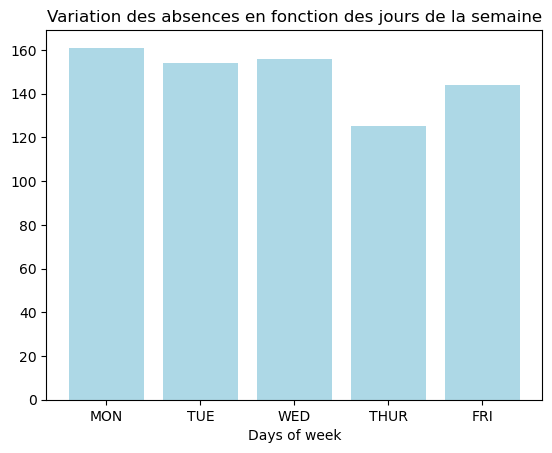

In [25]:
semaines_absence = df.groupby('Day of the week')['Absenteeism time in hours'].count()
semaines_absence=np.array(semaines_absence)

plt.bar(x=np.arange(len(semaines_absence)),height=semaines_absence,color='lightblue')

plt.xlabel('Days of week')
plt.xticks(np.arange(len(semaines_absence)),['MON','TUE','WED','THUR','FRI'])
plt.title("Variation des absences en fonction des jours de la semaine")
plt.show()

- Son & Absenteeims time

On remarque que les gens avec 2 et 3 enfants ont la durée d'absence moyenne la plus longue.

In [26]:
df.groupby('Son')['Absenteeism time in hours'].mean()


Son
0     5.385906
1     6.030568
2    10.570513
3    12.200000
4     7.285714
Name: Absenteeism time in hours, dtype: float64

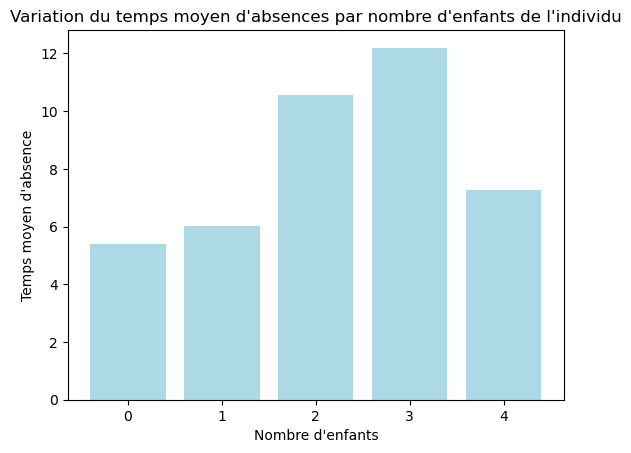

In [27]:
absence_child = np.array(df.groupby('Son')['Absenteeism time in hours'].mean())

plt.bar(x=np.arange(len(absence_child )),height=absence_child  ,color='lightblue')
plt.xlabel("Nombre d'enfants")
plt.ylabel("Temps moyen d'absence")
plt.title("Variation du temps moyen d'absences par nombre d'enfants de l'individu")
plt.show()

- Social drinker & Absenteeism time

Les fumeurs ont une durée moyenne d'absence plus longue mais la différence est juste d'environ 1h.

In [28]:
df.groupby('Social drinker')['Absenteeism time in hours'].mean()

Social drinker
0    5.931250
1    7.680952
Name: Absenteeism time in hours, dtype: float64

- Social smoket & Absenteeism time

Presque pas de différence

In [29]:
df.groupby('Social smoker')['Absenteeism time in hours'].mean()

Social smoker
0    6.957726
1    6.500000
Name: Absenteeism time in hours, dtype: float64

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               740 non-null    int64  
 1   Reason for absence               740 non-null    int64  
 2   Month of absence                 740 non-null    int64  
 3   Day of the week                  740 non-null    int64  
 4   Seasons                          740 non-null    int64  
 5   Transportation expense           740 non-null    int64  
 6   Distance from Residence to Work  740 non-null    int64  
 7   Service time                     740 non-null    int64  
 8   Age                              740 non-null    int64  
 9   Work load Average/day            740 non-null    float64
 10  Hit target                       740 non-null    int64  
 11  Disciplinary failure             740 non-null    int64  
 12  Education             

- Age & Absenteeism time

L'age n'influe On remarque un outlier avec plus un absence moyenne de 35h.


Text(0.5, 1.0, 'Average Absenteeism time in hours by Age')

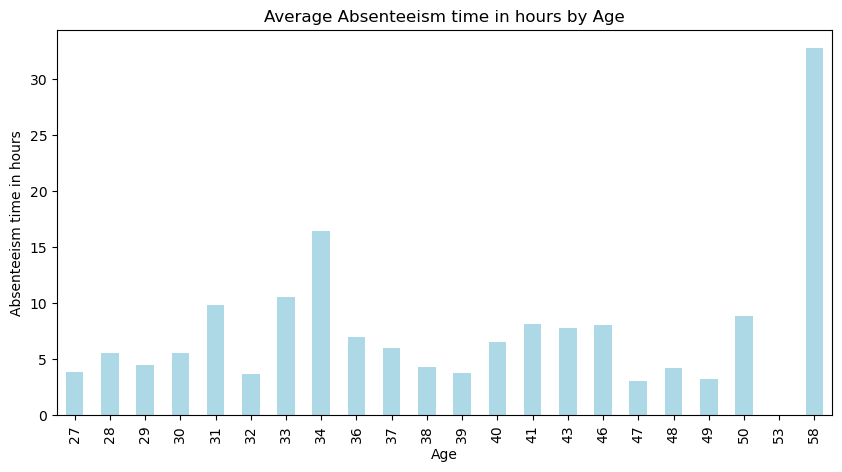

In [31]:
absence_age = df.groupby('Age')['Absenteeism time in hours'].mean()

absence_age.plot(kind='bar', figsize=(10,5), color="lightblue" )
plt.xlabel('Age')
plt.ylabel('Absenteeism time in hours')
plt.title('Average Absenteeism time in hours by Age')



In [462]:
"""
def group_age(age):
    if age >= 0:
        if age % 10 != 0:
            lower = int(math.floor(age/10.0))*10
            upper = int(math.ceil(age/10.0))*10-1
            return f"{lower}-{upper}"
        else:
            lower = int(age)
            upper = int(age+9)
            return f"{lower}-{upper}"
        return np.nan 
"""

In [463]:
"""df["age_range"] = df["Age"].apply(group_age)
age_order=df['age_range'].unique() """




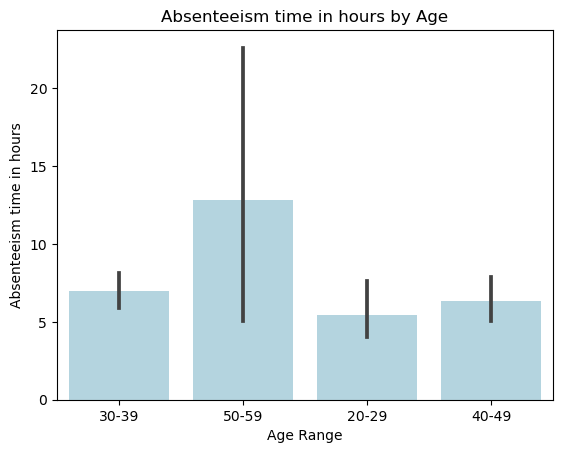

In [464]:
"""
sns.barplot(x='age_range',y='Absenteeism time in hours',data=df, color="lightblue")
plt.xlabel('Age Range')
plt.ylabel('Absenteeism time in hours')
plt.title('Absenteeism time in hours by Age')
plt.show() 

"""

In [42]:
imc = [0, 18.4, 24.9, 29.9, 39.9]
df['bmi'] = pd.cut(df['Body mass index'], bins=imc, labels=[f'IMC {i}' for i in range(1, len(imc))])

In [43]:
df1.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours,bmi
0,11,26,7,3,1,289,36,13,33,239.554,...,1,2,1,0,1,90,172,30,4,"(29.9, 39.9]"
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,0,0,98,178,31,0,"(29.9, 39.9]"
2,3,23,7,4,1,179,51,18,38,239.554,...,1,0,1,0,0,89,170,31,2,"(29.9, 39.9]"
3,7,7,7,5,1,279,5,14,39,239.554,...,1,2,1,1,0,68,168,24,4,"(18.4, 24.9]"
4,11,23,7,5,1,289,36,13,33,239.554,...,1,2,1,0,1,90,172,30,2,"(29.9, 39.9]"


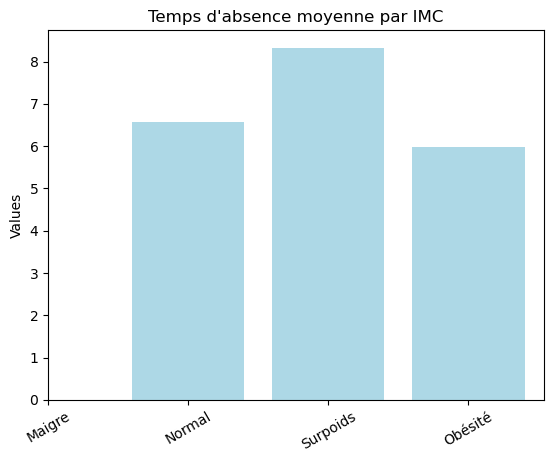

In [49]:
bmi=df1.groupby('bmi')['Absenteeism time in hours'].mean()
plt.bar(x=np.arange(len(bmi)),height=bmi,color='lightblue')
plt.ylabel('Values')
plt.xticks(np.arange(len(bmi)),['Maigre','Normal','Surpoids','Obésité'],rotation=30)
plt.title("Temps d'absence moyenne par IMC")
plt.show()

### Corrélation des variables

Text(0.5, 1.0, 'Correlation Heatmap')

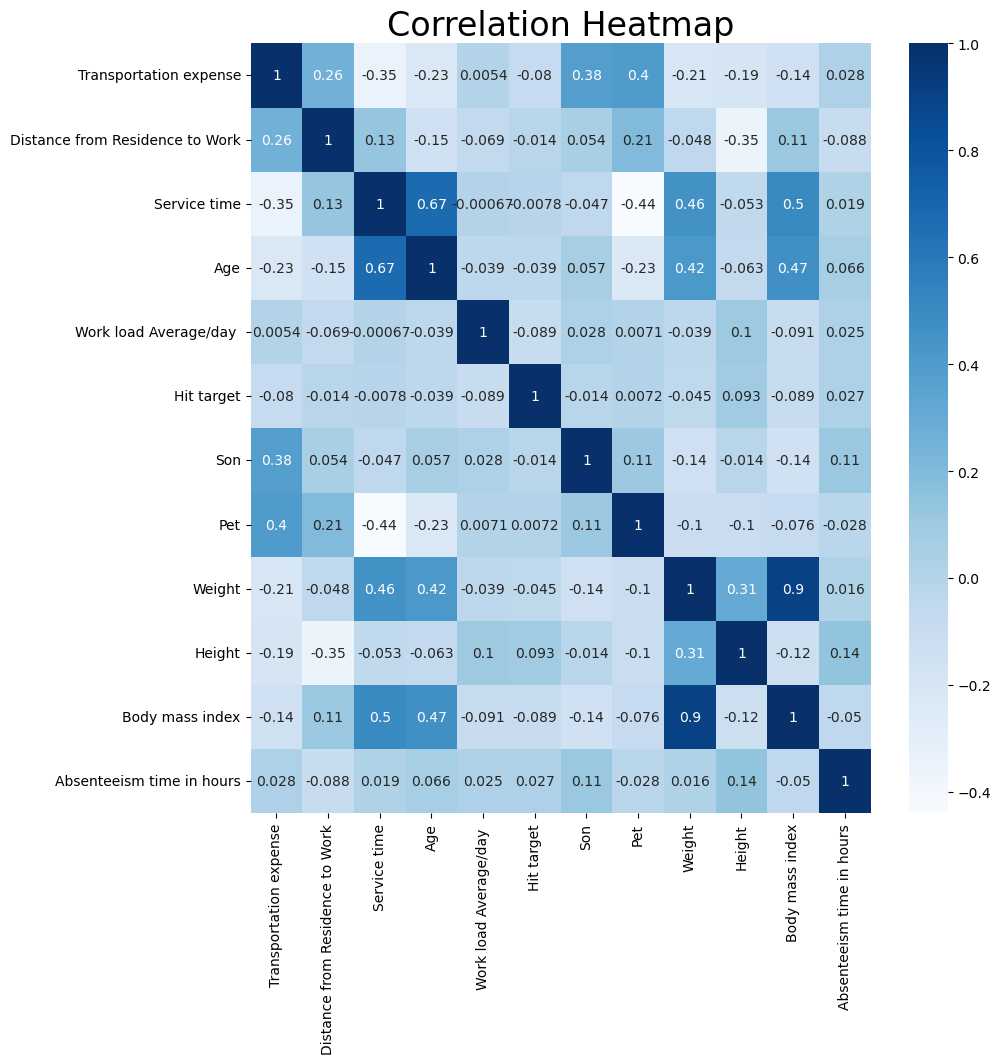

In [101]:
df_corr = df.drop(columns = ['ID', 'Disciplinary failure', 'Social drinker', 'Social smoker', 'Seasons', 
                            'Month of absence', 'Day of the week', 'Reason for absence', 'Education'])
corr = df_corr.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, annot = True,cmap='Blues')
plt.title('Correlation Heatmap', fontsize = 24)

<a name="models"></a>
# Models 

In [67]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

 ###  Naive Bayes
 
On commence d'abord par un simple modèle Naive Bayes 

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               740 non-null    int64  
 1   Reason for absence               740 non-null    int64  
 2   Month of absence                 740 non-null    int64  
 3   Day of the week                  740 non-null    int64  
 4   Seasons                          740 non-null    int64  
 5   Transportation expense           740 non-null    int64  
 6   Distance from Residence to Work  740 non-null    int64  
 7   Service time                     740 non-null    int64  
 8   Age                              740 non-null    int64  
 9   Work load Average/day            740 non-null    float64
 10  Hit target                       740 non-null    int64  
 11  Disciplinary failure             740 non-null    int64  
 12  Education             


En faisant un modèle avec et sans la variable "ID", on remarque qu'on obtient de meilleur résultat avec la variable ID. 

#### Modèle avec la variable ID
    - Accuracy de 30%

In [81]:
x = df.drop(['Absenteeism time in hours'], axis=1)
y = df[["Absenteeism time in hours"]]

In [85]:
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size = 0.7,random_state = 3)

In [83]:
model_NB = GaussianNB().fit(x_train,y_train)


/opt/miniconda3/envs/gfp/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [86]:
y_pred = model_NB.predict(x_test)
accuracy = accuracy_score(y_test, y_pred) * 100
print(accuracy)

29.27927927927928


#### Modèle sans la variable ID
    - Accuracy de 25%

In [87]:
x = df.drop(["ID",'Absenteeism time in hours'], axis=1)
y = df[["Absenteeism time in hours"]]

In [91]:
x_train, x_test, y_train,y_test = train_test_split(x,y, train_size = 0.70, random_state = 3)

In [92]:
model_NB = GaussianNB().fit(x_train,y_train)

/opt/miniconda3/envs/gfp/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [93]:
y_pred = model_NB.predict(x_test)
accuracy = accuracy_score(y_test, y_pred) * 100
print(accuracy)

24.774774774774773


#### Conclusion modèle Naive Bayes

On obtient un modèle pas très efficace avec une accuracy de seulement 30%.

### Modèle de decison tree

In [94]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [95]:
model = DecisionTreeClassifier(criterion = "gini" ).fit(x_train,y_train)

In [96]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_pred,y_test) * 100
print(accuracy)


42.792792792792795


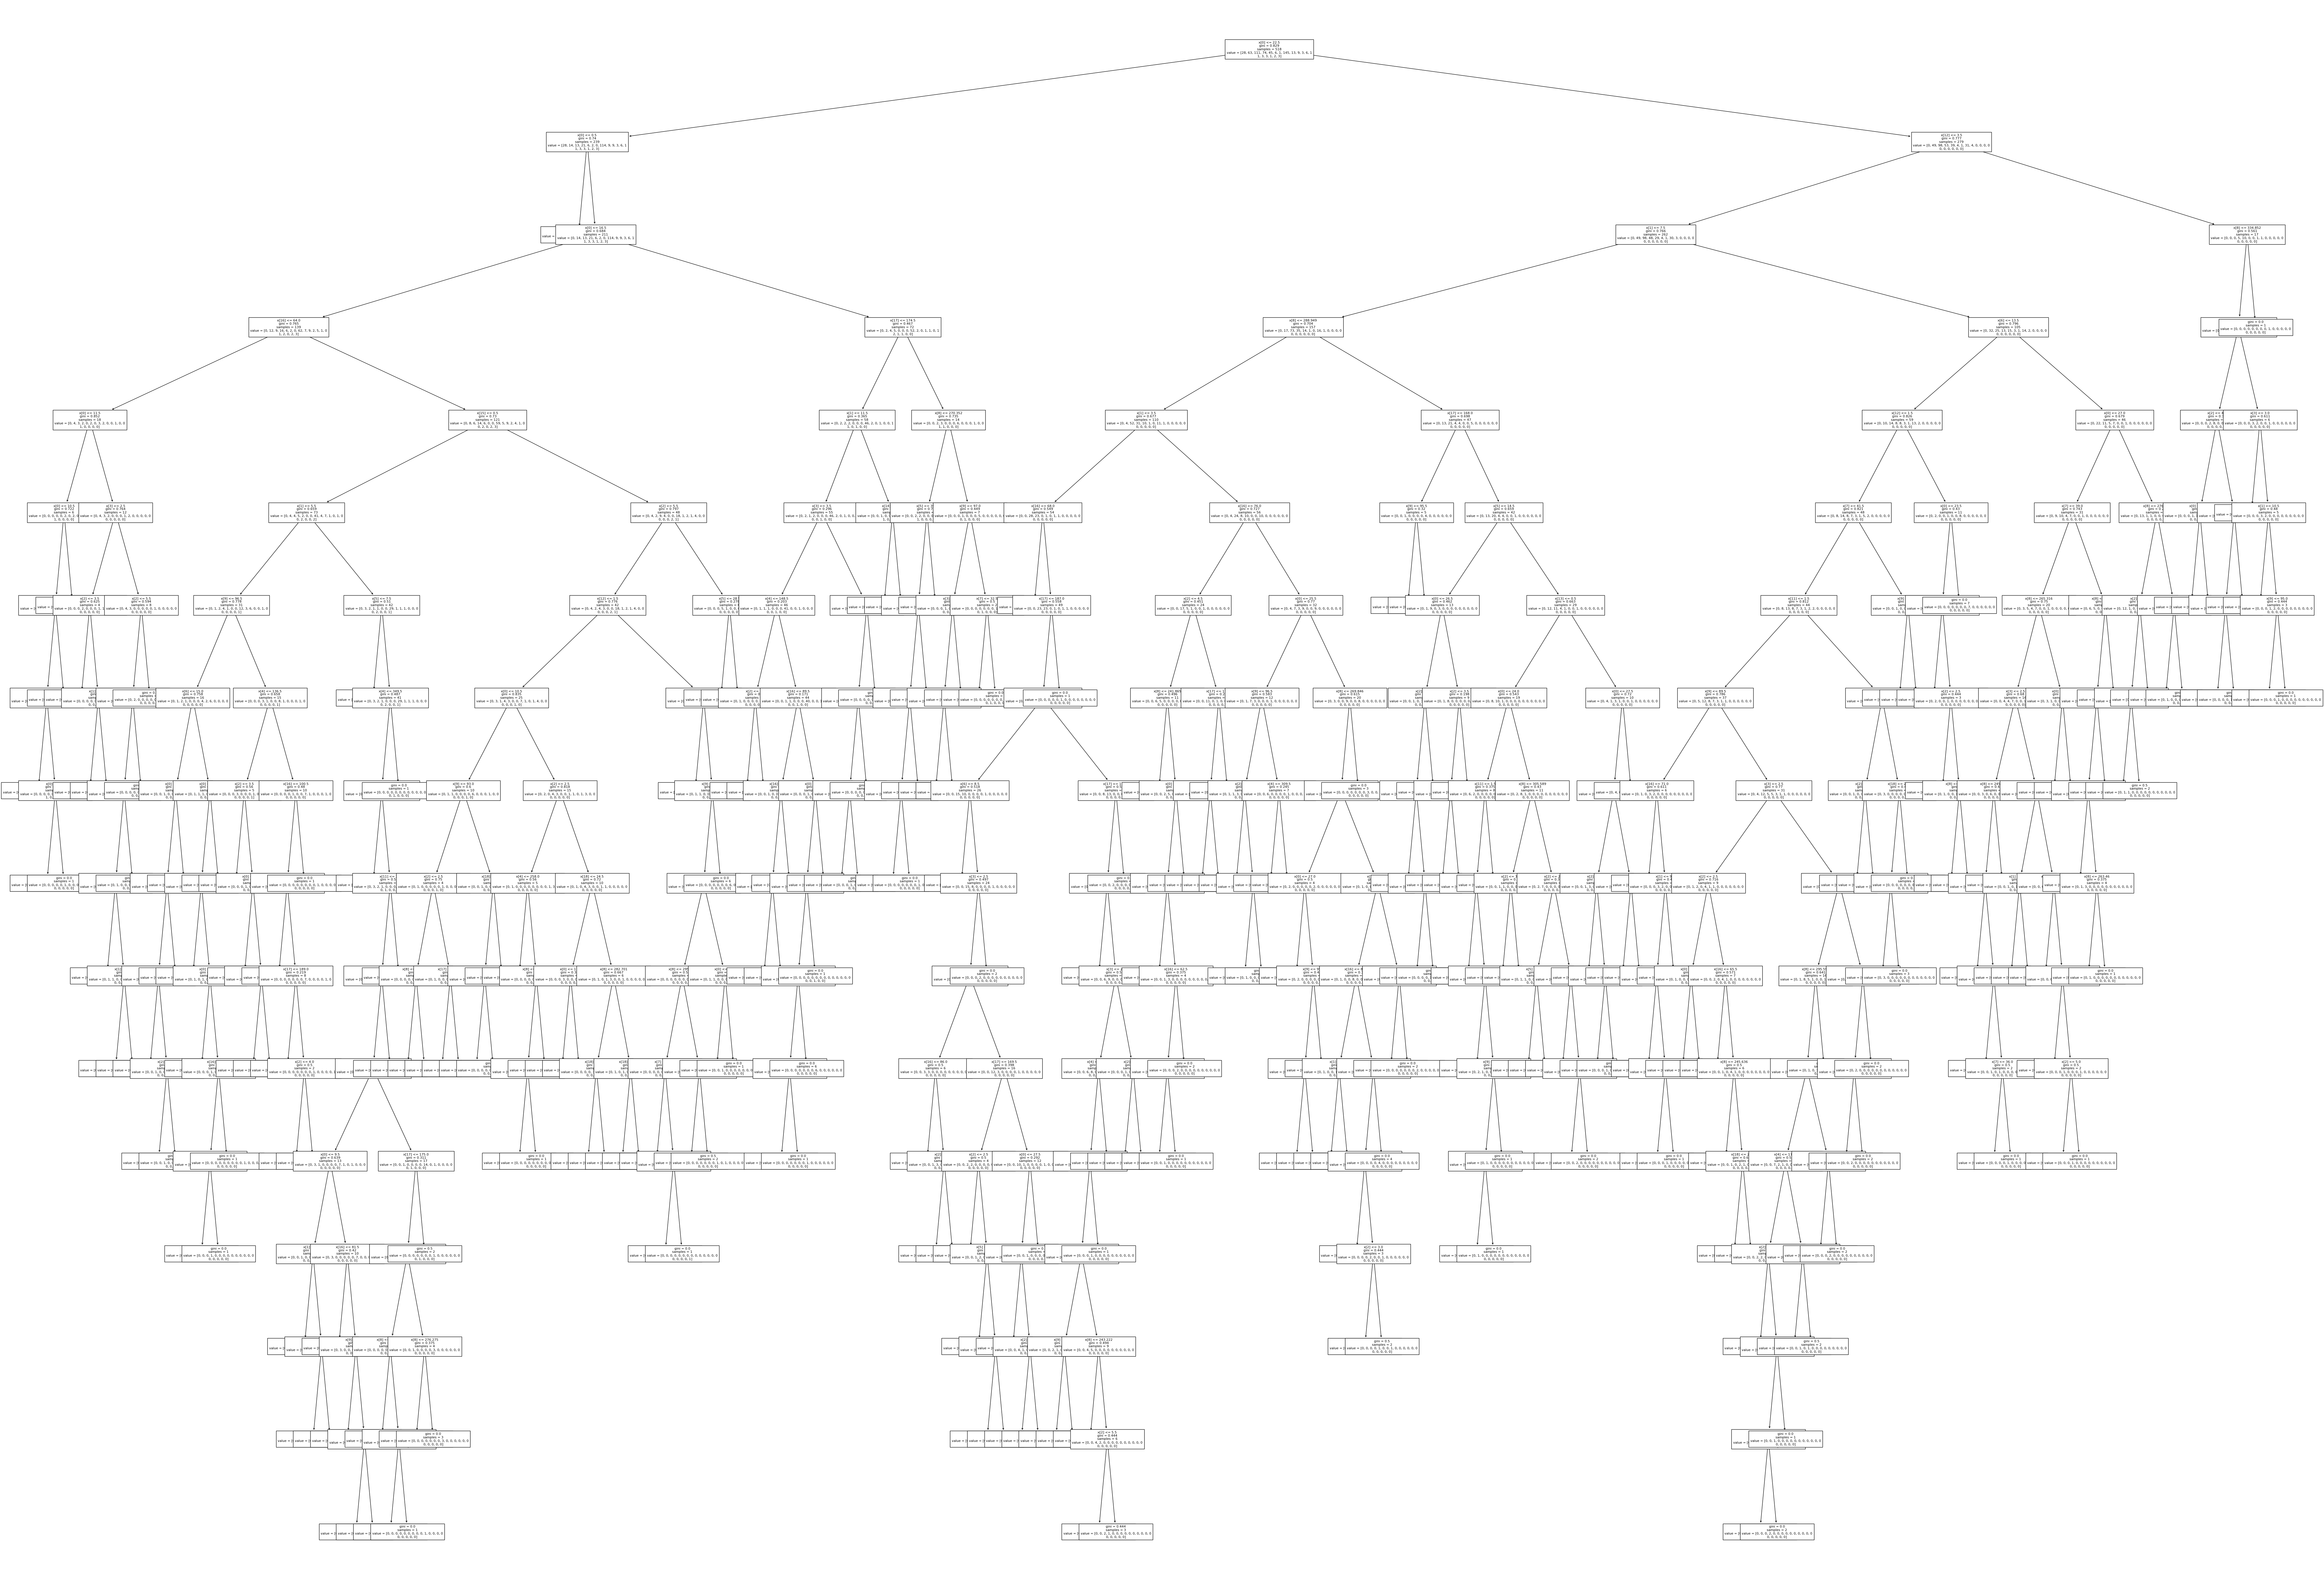

In [97]:
plt.figure(figsize=(100,70)) 
plot_tree(model, fontsize=8)
plt.show()

### Modèle de RandomForest

In [98]:
from sklearn.ensemble import RandomForestClassifier

In [99]:
model = RandomForestClassifier(max_depth=2, random_state=0).fit(x_train,y_train)


/opt/miniconda3/envs/gfp/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [100]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_pred,y_test) * 100
print(accuracy)

45.4954954954955
